In [1]:
import json 
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

import sklearn
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
loans = pd.read_csv('lending-club-data.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

In [4]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

Skipping observations with missing values :

In [5]:
loans = loans[[target] + features].dropna()

Make sure the classes are balanced :

In [6]:
categorical_variables = []
for feat_name, feat_type in zip(loans.columns, loans.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)
        
for feature in categorical_variables:
    
    loans_one_hot_encoded = pd.get_dummies(loans[feature],prefix=feature)
    loans_one_hot_encoded.fillna(0)
    #print loans_one_hot_encoded
    
    loans = loans.drop(feature, axis=1)
    for col in loans_one_hot_encoded.columns:
        loans[col] = loans_one_hot_encoded[col]

In [7]:
with open('module-8-assignment-1-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('module-8-assignment-1-validation-idx.json') as validation_data_file:    
    validation_idx = json.load(validation_data_file)

train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]
print (len(loans.dtypes ))

45


Gradient boosted tree classifier :

In [8]:
train_Y = train_data['safe_loans'].values
train_X = train_data.drop('safe_loans', axis=1).values

model_5 = GradientBoostingClassifier(n_estimators=5, max_depth=6).fit(train_X, train_Y)

Making predictions :

In [9]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [10]:
predicted_safe_loan = model_5.predict(sample_validation_data.drop('safe_loans', axis=1).values)
percentage = Counter(predicted_safe_loan == sample_validation_data['safe_loans'].values)[True]/len(sample_validation_data['safe_loans'].values)

print("predictions :", predicted_safe_loan)
print("Actal value :", sample_validation_data['safe_loans'].values)
print("percentage of the correct predictions of model_5 on sample_validation_data is", percentage)

predictions : [ 1  1 -1  1]
Actal value : [ 1  1 -1 -1]
percentage of the correct predictions of model_5 on sample_validation_data is 0.75


Prediction Probabilities :

In [11]:
print("The loan which has the highest probability of being classified as a safe loan is number 3")
model_5.predict_proba(sample_validation_data.drop('safe_loans', axis=1).values)

The loan which has the highest probability of being classified as a safe loan is number 3


array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

Evaluating the model on the validation data :

In [12]:
validation_Y = validation_data['safe_loans'].values
validation_X = validation_data.drop('safe_loans', axis=1).values

score = model_5.score(validation_X,validation_Y)
predictions = model_5.predict(validation_X)

print("scores are  :", score)
print("predictions : {}\n".format(predictions))

false_positives = ((predictions==1) * (validation_Y==-1)).sum()
false_negatives = ((predictions==-1) * (validation_Y==1)).sum()

print("the number of false positives on the validation_data is :", false_positives)
print("the number of false negatives on the validation_data is :", false_negatives)

scores are  : 0.6612451529513141
predictions : [-1  1 -1 ... -1 -1 -1]

the number of false positives on the validation_data is : 1654
the number of false negatives on the validation_data is : 1491


Comparison with decision trees :

In [13]:
cost = 10000 * false_negatives + 20000 * false_positives
print("\nThe cost of mistake made by the boosted tree model (model_5) as evaluated on the validation_set would be :\n", cost)


The cost of mistake made by the boosted tree model (model_5) as evaluated on the validation_set would be :
 47990000


Most positive & negative loans :

In [14]:
index=0
predictions = pd.Series([])
predictions_prob = model_5.predict_proba(validation_X)
for i in predictions_prob:
    predictions[index] = predictions_prob[index,1]
    index += 1

validation_data.insert(validation_data.shape[1], "predictions", predictions) 
validation_data.sort_values('predictions', ascending=False).head(5)

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,predictions
278,1,0.2,0,7,8.38,4.57015,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.673059
4865,1,0.4,0,8,15.29,4.67235,0.0,1.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0.661468
6905,-1,0.8,0,11,10.98,1.82480,0.0,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.661468
8771,1,1.0,0,2,7.16,3.17019,1.0,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0.661468
4789,1,0.4,0,5,15.23,9.21112,0.0,1.0,1.0,1,...,0,1,0,0,0,0,0,0,0,0.661468


In [15]:
print ("Your loans      : %s\n" % validation_data.sort_values('predictions', ascending=False)['predictions'].head(5))
print (validation_data.sort_values('predictions', ascending=False).head(5)[['grade_A','grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']])

Your loans      : 278     0.673059
4865    0.661468
6905    0.661468
8771    0.661468
4789    0.661468
Name: predictions, dtype: float64

      grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
278         0        1        0        0        0        0        0
4865        0        0        0        0        1        0        0
6905        1        0        0        0        0        0        0
8771        0        1        0        0        0        0        0
4789        1        0        0        0        0        0        0


In [16]:
print ("Your loans      : %s\n" % validation_data.sort_values('predictions', ascending=True)['predictions'].head(5))
print (validation_data.sort_values('predictions', ascending=True).head(5)[['grade_A','grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']])

Your loans      : 2980    0.332043
1932    0.336647
1540    0.342555
26      0.343841
1854    0.344973
Name: predictions, dtype: float64

      grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
2980        0        0        0        0        1        0        0
1932        0        0        0        0        1        0        0
1540        0        1        0        0        0        0        0
26          0        1        0        0        0        0        0
1854        0        1        0        0        0        0        0


Effects of adding more trees :

In [17]:
model_10  = GradientBoostingClassifier(n_estimators=10 , max_depth=6).fit(train_X, train_Y)
model_50  = GradientBoostingClassifier(n_estimators=50 , max_depth=6).fit(train_X, train_Y)
model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6).fit(train_X, train_Y)
model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6).fit(train_X, train_Y)
model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6).fit(train_X, train_Y)

Compare accuracy on entire validation set :

In [18]:
score = []
score.append(model_10.score (validation_X,validation_Y))
score.append(model_50.score (validation_X,validation_Y))
score.append(model_100.score(validation_X,validation_Y))
score.append(model_200.score(validation_X,validation_Y))
score.append(model_500.score(validation_X,validation_Y))

index = 0
best_score = 0
best_score_index = 0

for i in score :
    if best_score < i :
        best_score = i
        best_score_index = index
    index +=1
        
if best_score_index == 0 :
    print ("Model_10  the best accuracy on the validation_data")
elif best_score_index == 1:
    print ("Model_50  the best accuracy on the validation_data")
elif best_score_index == 2:
    print ("Model_100 the best accuracy on the validation_data")
elif best_score_index == 3:
    print ("Model_500 the best accuracy on the validation_data")
elif best_score_index == 4:
    print ("Model_500 the best accuracy on the validation_data")
    

print ("And its accuracy on the validation_data is :", best_score)

Model_500 the best accuracy on the validation_data
And its accuracy on the validation_data is : 0.6896811719086601


It is not always true that the model with the most trees will perform best on test data.

Plot the training and validation error vs. number of trees :

In [19]:
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [20]:
train_err_10  = 1-model_10.score (train_X,train_Y)
train_err_50  = 1-model_50.score (train_X,train_Y)
train_err_100 = 1-model_100.score(train_X,train_Y)
train_err_200 = 1-model_200.score(train_X,train_Y)
train_err_500 = 1-model_500.score(train_X,train_Y)

training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

In [21]:
validation_err_10  = 1-model_10.score (validation_X,validation_Y)
validation_err_50  = 1-model_50.score (validation_X,validation_Y)
validation_err_100 = 1-model_100.score(validation_X,validation_Y)
validation_err_200 = 1-model_200.score(validation_X,validation_Y)
validation_err_500 = 1-model_500.score(validation_X,validation_Y)

validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

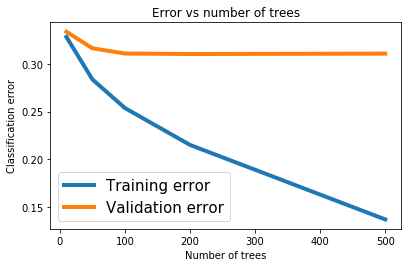

In [22]:
plt.plot([10, 50, 100, 200, 500], training_errors  , linewidth=4.0, label='Training error'  )
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

So according to the plot, training error reduce as the number of trees increases, And the validation error will not reduce as the number of trees increases.